# Test Different Weight and Bias Values on Fashion MNIST Dataset

Load imports. Make sure that onnx is imported before Torch. __ONNX is always imported before Torch__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

## Load The Fashion MNIST Dataset Using PyTorch

Here we load the Fashion MNIST dataset using `torchvision.datasets.FashionMNIST`, and specify that we want to download the dataset if it isn't already downloaded. We also use the transform argument to apply the `transforms.Compose([transforms.ToTensor()])` transformation to each image, which converts the images from PIL Images to PyTorch Tensors.

We then wrap the `train_set` and `test_set` datasets in PyTorch `DataLoader` objects, which allow us to load the data in batches for more efficient processing during training and testing.

Finally, we use `next(iter(train_loader))` to retrieve the first batch of training data from the `train_loader`, and print the size of the batch and the total number of training examples in train_set.

In [2]:
# Load Fashion MNIST dataset
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

# Loaders
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=1000)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1000)

a = next(iter(train_loader))
print(a[0].size())
print(len(train_set))

print("Samples in each set: train = %d, test = %s" % (len(train_set), len(train_loader))) 
print("Shape of one input sample: " +  str(train_set[0][0].shape))

torch.Size([1000, 1, 28, 28])
60000
Samples in each set: train = 60000, test = 60
Shape of one input sample: torch.Size([1, 28, 28])


9


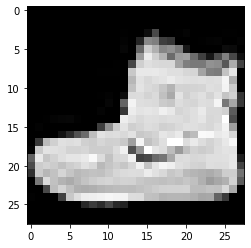

In [3]:
image, label = next(iter(train_set))

plt.imshow(image.squeeze(), cmap="gray")
print(label)

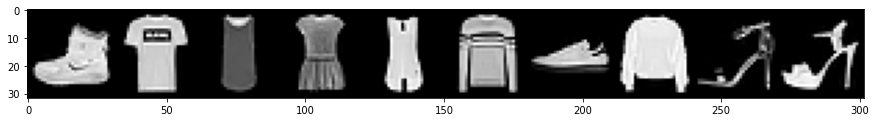

In [4]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

## Data Loader

Using PyTorch dataloader we can create a convenient iterator over the dataset that returns batches of data, rather than requiring manual batch creation. 

In [5]:
# set batch size
batch_size = 1000

# Create a DataLoader for a training dataset with a batch size of 100
train_quantized_loader = DataLoader(train_set, batch_size=batch_size)
test_quantized_loader = DataLoader(test_set, batch_size=batch_size)

# Get the first batch from the demo_loader
batch = next(iter(demo_loader))

# Split the batch into images and labels tensors
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


In [6]:
count = 0
for x,y in train_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([1000, 1, 28, 28])
Label shape for 1 batch: torch.Size([1000])


# Define a PyTorch Device

GPUs can significantly speed-up training of deep neural networks. We check for availability of a GPU and if so define it as target device.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Define the Quantized Model

In [8]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [10]:
model = FashionCNN().to(device)

learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Train and Test

This code trains a convolutional neural network (CNN) on the Fashion MNIST dataset using PyTorch. The code uses the torchvision module to download and preprocess the dataset, and defines a CNN with two convolutional layers, two max-pooling layers, and three fully connected layers. The code uses the cross-entropy loss function and the Adam optimizer to train the model.

To run the code, first make sure PyTorch and torchvision are installed on your system. Then, run the code in a Python environment. The code should automatically download the Fashion MNIST dataset and train the model for 20 epochs.

During training, the code prints the loss after every 100 batches. After each epoch, the code evaluates the model on the test set and prints the test accuracy.

In [12]:
num_epochs = 15
for epoch in range(num_epochs):
    # training phase
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Epoch [{}/{}], Test Accuracy: {:.2f}%'.format(epoch+1, num_epochs, 100 * correct / total))


Epoch [1/15], Test Accuracy: 86.86%
Epoch [2/15], Test Accuracy: 88.89%
Epoch [3/15], Test Accuracy: 89.61%
Epoch [4/15], Test Accuracy: 89.60%
Epoch [5/15], Test Accuracy: 89.37%
Epoch [6/15], Test Accuracy: 89.41%
Epoch [7/15], Test Accuracy: 89.61%
Epoch [8/15], Test Accuracy: 89.89%
Epoch [9/15], Test Accuracy: 89.50%
Epoch [10/15], Test Accuracy: 90.18%
Epoch [11/15], Test Accuracy: 89.57%
Epoch [12/15], Test Accuracy: 89.40%
Epoch [13/15], Test Accuracy: 89.20%
Epoch [14/15], Test Accuracy: 89.70%
Epoch [15/15], Test Accuracy: 89.97%


## Changing Model Parameters (Weights/Biases)

First we show how to get the trained_state_dictionary which shows all weights, biases etc. Then we also show how to extract just one layers weights.

In [17]:
# Get all model Parameters
trained_state_dict = model.state_dict()

# Get individual weights from layers
weight_layer1 = model.state_dict()['layer1.0.weight']

OrderedDict([('layer1.0.weight',
              tensor([[[[ 1.3497e-01,  6.0186e-02, -2.0444e-01],
                        [ 6.0343e-02,  1.5091e-01,  2.4252e-01],
                        [ 2.5391e-01,  2.9217e-01, -2.5044e-01]]],
              
              
                      [[[-2.1216e-01, -9.6908e-02,  2.1365e-01],
                        [-2.1143e-01,  2.2037e-01,  1.0120e-01],
                        [ 2.3934e-01, -3.5285e-01,  1.3441e-01]]],
              
              
                      [[[ 2.2220e-01,  2.7089e-01, -4.0338e-01],
                        [ 1.9229e-01, -1.3887e-01,  1.4847e-01],
                        [-2.9832e-01, -2.5009e-01,  2.6660e-01]]],
              
              
                      [[[-1.3486e-01,  8.7801e-02, -1.6671e-01],
                        [-1.6114e-01, -1.4849e-01,  2.0666e-02],
                        [ 3.0232e-01,  1.4119e-01,  2.5135e-01]]],
              
              
                      [[[ 1.8581e-01, -2.8810e-01,  3.0697e

In [43]:
def test(model, test_loader):
# testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            
    accuracy = 100 * correct / total
    return accuracy


In [44]:
# Sigma is weight dependent
# Range is clipped to wmin/wmax

# Add noise to weight and or bias matrices. 
# The weight is a centered normal around the weight values with a sigma difference.

def add_noise(matrix, sigma):
    
    noised_weight = np.random.normal(loc=matrix, scale=sigma)
    
    return noised_weight

In [45]:
def add_noise_to_model(model, layers, sigma):
    
    modified_model = deepcopy(model)
    
    for i in range(len(layers)):
        
        layer_name = f'layer{i + 1}'
        layer = getattr(modified_model, layer_name)
    
        # get weight and bias for layer
        weight_temp = layer[0].weight.data.detach().numpy()
        bias_temp = layer[0].bias.data.detach().numpy()
    
        
        # add noise to the weight and bias
        noise_w = add_noise(weight_temp, sigma)
        noise_b = add_noise(bias_temp, sigma)
    
        
        # place values back into the modified model for analysis
        layer[0].weight.data = torch.from_numpy(noise_w).float()
        layer[0].bias.data = torch.from_numpy(noise_b).float()
        
    return modified_model


In [46]:
# Define the standard deviation values to test
sigma_vector = np.linspace(0, 0.2, 11)

# Define the layer to add noise to
layers = [1]

# Loop over each standard deviation value in sigma_vector
for s in range(len(sigma_vector)):
    
    # Print the current standard deviation value
    print(sigma_vector[s])

    # Add noise to the model for the defined layer only
    noisy_model = add_noise_to_model(model, layers, sigma_vector[s])
    
    # Move the model back to the target device
    noisy_model.to(device)
    
    # Test the accuracy of the noisy model and print the result
    print(test(noisy_model, test_quantized_loader))

0.0
89.97
0.02
88.14
0.04
75.65
0.06
69.11
0.08
76.34
0.1
51.56
0.12
27.54
0.14
31.41
0.16
37.59
0.18
31.0
0.2
18.67


## Plotting Analysis

This code is exploring the effect of adding Gaussian noise to a trained Fashion CNN model on its test accuracy. It first initializes the standard deviation values to be tested and loops over each layer of the model. Within each layer loop, the code initializes an empty list to store the test accuracies for that layer, and then loops over each standard deviation value in the sigma vector. For each standard deviation value, the code creates a copy of the original model and adds Gaussian noise to the parameters of the specified layer only. Then, it tests the accuracy of the noisy model on a quantized test dataset and appends the result to the list of test accuracies for that layer. The code then plots the test accuracies as a function of the standard deviation for that layer.

After looping over all layers and plotting the test accuracies for each layer, the code initializes an empty list to store the averaged test accuracies for each standard deviation value. It then loops over each layer again, adds noise to the specified layer of the model for each standard deviation value, and tests the accuracy of the noisy model. For each standard deviation value, it appends the test accuracy to the corresponding element of the averaged test accuracies list. The code then plots the test accuracies for each layer as a function of the standard deviation on the same graph and plots the averaged test accuracies as a function of the standard deviation on a separate line. Finally, the code adds labels to the plot and displays it. 

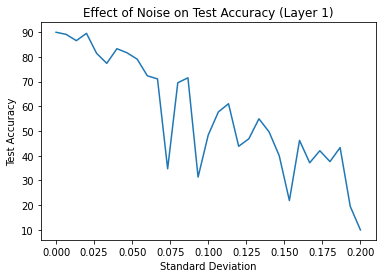

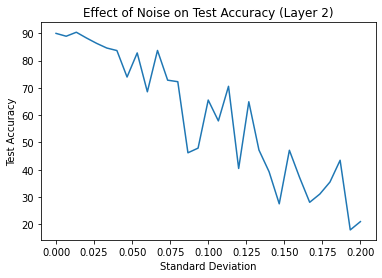

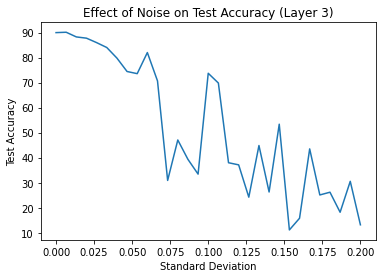

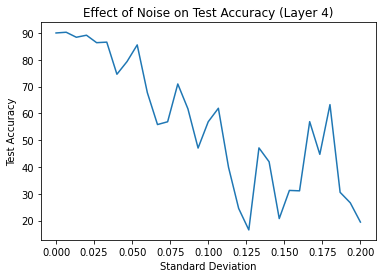

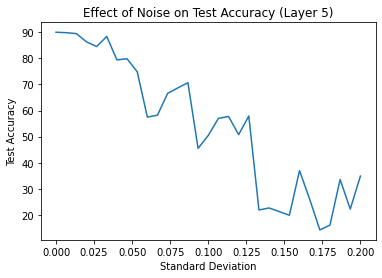

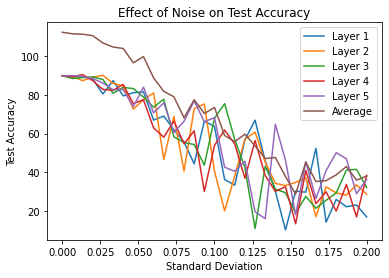

In [49]:
import matplotlib.pyplot as plt

# Initialize the standard deviation values
sigma_vector = np.linspace(0, 0.2, 31)

# Loop over each layer and plot the test accuracy as a function of the standard deviation for that layer
for layer in [1,2,3,4,5]:
    
    # Initialize a list to store the test accuracies for this layer
    test_accs = []
    
    # Iterate over the standard deviation values and add noise to the model for this layer only
    for sigma in sigma_vector:
        noisy_model = add_noise_to_model(model, [layer], sigma)
        noisy_model.to(device)

        # Test the accuracy of the noisy model and append the result to the list of test accuracies
        test_acc = test(noisy_model, test_quantized_loader)
        test_accs.append(test_acc)

    # Plot the test accuracies as a function of the standard deviation for this layer
    plt.plot(sigma_vector, test_accs)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of Noise on Test Accuracy (Layer {})'.format(layer))
    plt.show()


# Initialize the standard deviation values
sigma_vector = np.linspace(0, 0.2, 31)

# Initialize a list to store the averaged test accuracies for each standard deviation value
avg_test_accs = [0] * len(sigma_vector)

# Loop over each layer and add noise to the model for that layer only, and average the test accuracies across all layers
for layer in [1,2,3,4,5]:
    
    # Initialize a list to store the test accuracies for this layer
    test_accs = []
    
    # Iterate over the standard deviation values and add noise to the model for this layer only
    for sigma in sigma_vector:
        noisy_model = add_noise_to_model(model, [layer], sigma)
        noisy_model.to(device)

        # Test the accuracy of the noisy model and append the result to the list of test accuracies
        test_acc = test(noisy_model, test_quantized_loader)
        test_accs.append(test_acc)
        
        # Add the test accuracy to the corresponding element of the averaged test accuracies list
        avg_test_accs[sigma_vector.tolist().index(sigma)] += test_acc
    
    # Plot the test accuracies as a function of the standard deviation for this layer
    plt.plot(sigma_vector, test_accs, label='Layer {}'.format(layer))

# Average the test accuracies across all layers for each standard deviation value
avg_test_accs = [acc / len([0, 4, 8, 12]) for acc in avg_test_accs]

# Plot the averaged test accuracies as a function of the standard deviation
plt.plot(sigma_vector, avg_test_accs, label='Average')

# Set the plot labels and title
plt.xlabel('Standard Deviation')
plt.ylabel('Test Accuracy')
plt.title('Effect of Noise on Test Accuracy')

# Show the legend
plt.legend()

# Show the plot
plt.show()

#####
#  layer1 is the first convolutional layer, followed by batch normalization, ReLU activation, and max pooling
#  layer2 is the second convolutional layer, followed by batch normalization, ReLU activation, and max pooling
#  fc1 is the first fully connected layer
#  drop is the dropout layer
#  fc2 is the second fully connected layer
#  fc3 is the final fully connected layer (output layer)
#####